# Predict People Flow by using RNN

In [113]:
import numpy as np
import torch

In [114]:
import matplotlib.pyplot as plt
###### configurations for image quality#######
plt.rcParams["figure.figsize"] = [12, 6]   ##
# plt.rcParams['figure.dpi'] = 300           ## 300 for printing
plt.rc('font', size=8)                     ## 
plt.rc('axes', titlesize=16)               ## 
plt.rc('axes', labelsize=14)               ##
plt.rc('xtick', labelsize=10)              ##
plt.rc('ytick', labelsize=10)              ##
plt.rc('legend', fontsize=10)              ##
plt.rc('figure', titlesize=12)             ## 
#############################################

## Data Preparation

In [115]:
import pandas as pd

path = '../data/num_file/p003.csv'
p003 = pd.read_csv(path)

Merge "date" and "hour" columns to be datetime

In [116]:
p003['datetime'] = pd.to_datetime(p003['date'])+pd.to_timedelta(p003['hour'], unit='h')
p003 = p003.drop(['date', 'hour'], axis=1)
p003.set_index('datetime', inplace=True)
p003.columns=['y']
p003['y'] = p003['y'].astype(float)
print(p003)

                           y
datetime                    
2022-05-26 14:00:00   2680.0
2022-05-26 18:00:00  25768.0
2022-05-26 19:00:00  29898.0
2022-05-26 20:00:00  29425.0
2022-05-26 21:00:00  27602.0
...                      ...
2022-06-30 23:00:00  12735.0
2022-07-01 00:00:00   3457.0
2022-07-01 01:00:00   2616.0
2022-07-01 02:00:00   2296.0
2022-07-01 03:00:00   1531.0

[695 rows x 1 columns]


Resample the data that are not existed

In [117]:
p003 = p003.resample('H').mean()
p003.index.freq = 'H'
print(p003)

                           y
datetime                    
2022-05-26 14:00:00   2680.0
2022-05-26 15:00:00      NaN
2022-05-26 16:00:00      NaN
2022-05-26 17:00:00      NaN
2022-05-26 18:00:00  25768.0
...                      ...
2022-06-30 23:00:00  12735.0
2022-07-01 00:00:00   3457.0
2022-07-01 01:00:00   2616.0
2022-07-01 02:00:00   2296.0
2022-07-01 03:00:00   1531.0

[854 rows x 1 columns]


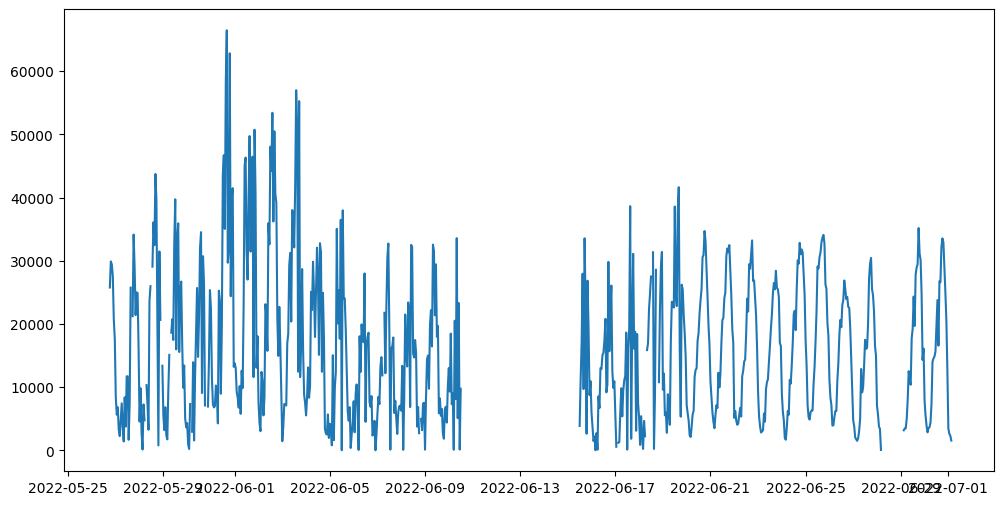

In [118]:
plt.plot(p003['y'])

In [119]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor, BaggingRegressor
from sklearn.linear_model import ElasticNet, LinearRegression

estimators = [
    # ('extra_trees', ExtraTreesRegressor(n_estimators=10)),
    ('bagging', BaggingRegressor(n_estimators=10)),
    # ('elastic_net', ElasticNet()),
    # ('linear_regression', LinearRegression()),
    # ('knn', KNeighborsRegressor(n_neighbors=3))
]

In [120]:
p003_vals = p003.iloc[:, 0:3].values

for e_name, e in estimators:
    est = IterativeImputer(random_state=15, estimator=e).fit(p003_vals)
    p003['y'] = est.transform(p003_vals)[:]

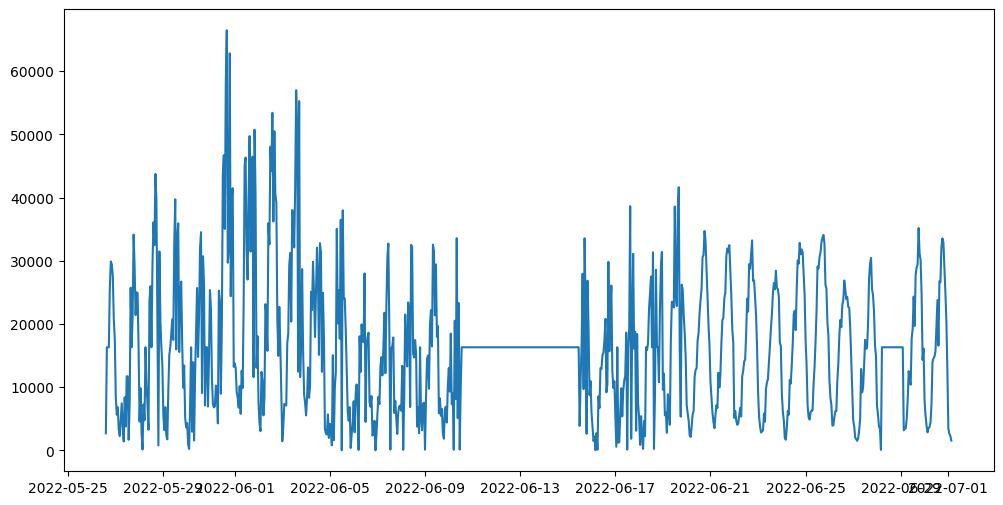

In [121]:
plt.plot(p003['y'])

# Transform the data

### Windowing

In [122]:
def handle_missing_data(df):
    n = int(df.isna().sum())
    if n > 0:
        print(f'found {n} missing observations...')
        df.ffill(inplace=True)
        
        
def one_step_forecast(df, window):
    d = df.values
    x = []
    n = len(df)
    idx = df.index[:-window]
    for start in range(n-window):
        end = start + window
        x.append(d[start:end])
    cols = [f'x_{i}' for i in range(1, window+1)]
    x = np.array(x).reshape(n-window, -1)
    y = df.iloc[window:].values
    df_xs = pd.DataFrame(x, columns=cols, index=idx)
    df_y = pd.DataFrame(y.reshape(-1), columns=['y'], index=idx)
    return pd.concat([df_xs, df_y], axis=1).dropna()
    

def split_data(df, test_split=0.15):
    n = int(len(df) * test_split)
    train, test = df[:-n], df[-n:]
    return train, test

In [123]:
p003_cp = p003.copy()
handle_missing_data(p003_cp)

/var/folders/7l/hpz3ccrd3_zdd3c0rbn38bnh0000gn/T/ipykernel_13443/3588771845.py:2: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  n = int(df.isna().sum())


In [124]:
p003_df = one_step_forecast(p003_cp, 1)
print(p003_df.shape)

(853, 2)


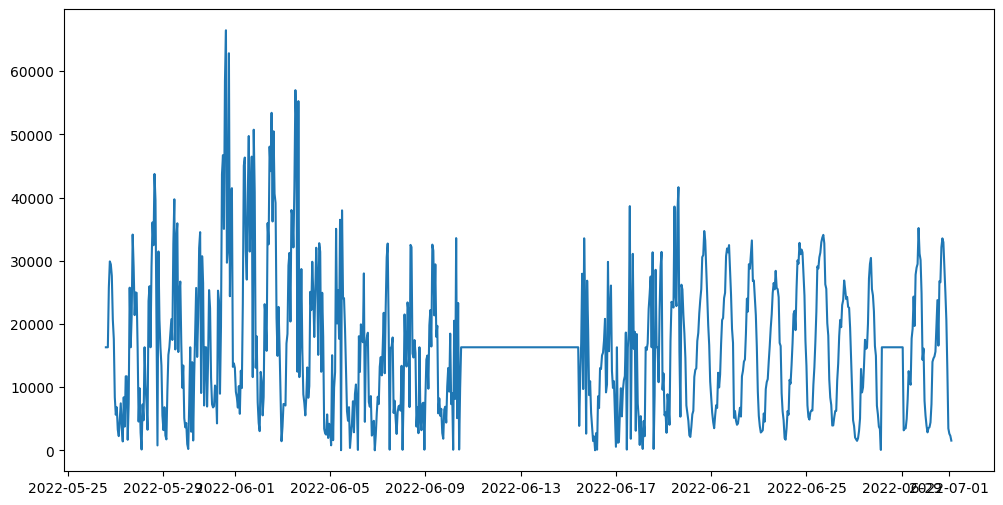

In [125]:
plt.plot(p003_df['y'])

### Scale and split data

In [126]:
class Standardize:
    def __init__(self, df, split=0.10):
        self.data = df
        self.split = split
    
    def split_data(self):
        n = int(len(self.data) * self.split)
        train, test = self.data.iloc[:-n], self.data.iloc[-n:]
        n = int(len(train) * self.split)
        train, val = train.iloc[:-n], train.iloc[-n:]
        assert len(test) + len(train) + len(val) == len(self.data)
        return train, test, val
    
    def _transform(self, data):
        data_s = (data - self.mu)/self.sigma
        return data_s
    
    def fit_transform(self):
        train, test, val = self.split_data()
        self.mu, self.sigma = train.mean(), train.std()
        train_s = self._transform(train)
        test_s = self._transform(test)
        val_s = self._transform(val)
        return train_s, test_s, val_s
    
    def inverse(self, data):
        return (data * self.sigma)+self.mu
        
    def inverse_y(self, data):
        return (data * self.sigma[-1])+self.mu[-1]

In [127]:
scale_p003 = Standardize(p003_df)
train_p003, test_p003, val_p003 = scale_p003.fit_transform()

In [128]:
print(f'''
train: {len(train_p003)}, test: {len(test_p003)}, val: {len(val_p003)}
      ''')


train: 692, test: 85, val: 76
      


### Split into X and Y (Features and Target)

Create the features_target_pt func to return a PyTorch Tensor object

In [129]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [130]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available and being used")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("GPU is available and being used")
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU instead")

GPU is available and being used


In [131]:
def features_target_pt(*args):
    y = [torch.from_numpy(col.pop('y').values.reshape(-1,1)).float() for col in args]
    x = [torch.from_numpy(col.values.reshape(*col.shape, 1)).float()
                   for col in args]
    return *y, *x

Split the train, validate, and test sets into x and y

In [132]:
(y_train, y_val, y_test, x_train, x_val, x_test) = features_target_pt(train_p003, val_p003, test_p003)

Check type and len

In [133]:
type(x_test)

torch.Tensor

In [134]:
y_train.shape

torch.Size([692, 1])

In [135]:
x_train.shape

torch.Size([692, 1, 1])

## RNN Model

The math from the PyTorch RNN class documentation

$$
\large
h_t = \tanh(W_{ih} x_t + b_{ih} + W_{hh} h_{(t-1)} + b_{hh})
$$

In [136]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, n_features, n_layers):
        super(RNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = n_features
        self.rnn = nn.RNN(input_size, n_features, n_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(n_features, output_size)
        
    def forward(self, x, hn):
        # batch_first=True -> (batch_size, seq_length, input_size)
        x = x.view(1, x.shape[0], x.shape[1])
        rnn_o, hn = self.rnn(x, hn)
        rnn_o = self.dropout(rnn_o)
        # reshape
        rnn_o = rnn_o.view(-1, self.hidden_dim)
        output = self.fc(rnn_o)
        return output, hn

    def init_hidden(self):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, 1, self.hidden_dim).zero_()
        return hidden

In [137]:
issubclass(RNN, nn.Module)

True

Create the train_model_pt func

In [138]:
def train_model_pt(model_type='RNN', **kwargs):
    """
    Parameters:
        input_size: input size
        output_size: output size
        n_features: number of features (hidden dimension)
        n_layers: number of layers
        train_data: tuple ex (x_train, y_train)
        val_data: tuple ex (x_val, y_val)
        epochs: number of epochs
        print_every: output and history tracking
        lr: learning rate
    """
    if model_type=='RNN':
        model = RNN(kwargs['input_size'], 
                    kwargs['output_size'], 
                    kwargs['units'], 
                    kwargs['n_layers'])
    elif model_type=='LSTM':
        model = LSTM(kwargs['input_size'], 
                    kwargs['output_size'], 
                    kwargs['units'], 
                    kwargs['n_layers'])
    elif model_type=='GRU':
         model = LSTM(kwargs['input_size'], 
                    kwargs['output_size'], 
                    kwargs['units'], 
                    kwargs['n_layers'])
        
    # Define Loss Function
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=kwargs['lr'])
    
    # Extract the training, testing and validation sets
    x_train, y_train = kwargs['train_data']
    x_val, y_val  = kwargs['val_data']
    x_test, y_test = kwargs['test_data']
    
    # Define a history object to keep track of the train and val loss
    history = {'loss': [], 'val_loss': []}
    # batch_size = x_train.shape[0]
    model.train()
    epochs = kwargs['epochs']
    print_every = kwargs['print_every']
    
    for batch_i, epoch in enumerate(range(epochs)):
        h = model.init_hidden()
        optimizer.zero_grad()
        pred, h = model(x_train, h) #model(x_train)
        #hidden = hidden.data
        loss = criterion(pred, y_train)        
        loss.backward()
        optimizer.step()
        if batch_i % print_every == 0:
            model.eval()
            with torch.no_grad():
                val_h = model.init_hidden()
                val_p, val_h = model(x_val, val_h)
                val_loss = criterion(val_p, y_val)
                history['val_loss'].append(val_loss.item())
            model.train()
            history['loss'].append(loss.item())
            print(f'{batch_i}/{epochs} - Loss:  {loss.item()}, val_loss: {val_loss.item()}')
    
    ## Prediction
    model.eval()
    with torch.no_grad():
        h0 = model.init_hidden()
        y_hat = model(x_test, h0)
    y_hat, _ = y_hat
    mse_loss_air = criterion(y_hat, y_test)
    print(f'Test MSE Loss: {mse_loss_air.item():.4f}')
    
    ## Plotting
    fig, ax = plt.subplots(2, 1) 

    ax[0].set_title(f'{model_type}: Loss and Validation Loss per epoch')
    ax[0].plot(history['loss'], 'k--', label='loss')
    ax[0].plot(history['val_loss'], 'k', label='val_loss')
    ax[0].legend()
    ax[1].set_title(f"{model_type} TEST MSE = {mse_loss_air.item():.4f}: Forecast vs Actual (Out-of-Sample data)")
    scale = kwargs['scale']
    actual = scale.inverse_y(y_test.detach().numpy().ravel())
    pred = scale.inverse_y(y_hat.detach().numpy().ravel())
    idx = kwargs['idx']
    pd.Series(actual, index=idx).plot(style='k--', label='actual', alpha=0.65)
    pd.Series(pred, index=idx).plot(style='k', label='forecast')
    fig.tight_layout()
    ax[1].legend(); plt.show()
    
    return model, history

In the preceding code, we are looping through each epoch, initializing the hidden state ($W_{hh}$). On each iteration, we will evaluate on the validation set and store both results from training and validation

### Training and Testing

In [139]:
params = {
    'input_size': x_train.shape[1],
    'output_size': 1,
    'units': 32,
    'n_layers': 1,
    'epochs': 1000,
    'print_every': 50,
    'lr': 0.01,
    'train_data': (x_train, y_train),
    'val_data': (x_val, y_val),
    'test_data': (x_test, y_test),
    'idx': test_p003.index,
    'scale': scale_p003
}

0/1000 - Loss:  0.9695278406143188, val_loss: 0.6138138175010681


50/1000 - Loss:  0.42843663692474365, val_loss: 0.13507632911205292
100/1000 - Loss:  0.3783915042877197, val_loss: 0.16267788410186768
150/1000 - Loss:  0.3508433997631073, val_loss: 0.14231383800506592
200/1000 - Loss:  0.3248370587825775, val_loss: 0.18091949820518494
250/1000 - Loss:  0.26774686574935913, val_loss: 0.23003527522087097
300/1000 - Loss:  0.2490549087524414, val_loss: 0.2429017573595047
350/1000 - Loss:  0.6356408596038818, val_loss: 0.15143583714962006
400/1000 - Loss:  0.4691881537437439, val_loss: 0.1252588927745819
450/1000 - Loss:  0.444180965423584, val_loss: 0.11852125078439713
500/1000 - Loss:  0.44064030051231384, val_loss: 0.1199418231844902
550/1000 - Loss:  0.42408907413482666, val_loss: 0.08877053111791611
600/1000 - Loss:  0.39697128534317017, val_loss: 0.08329044282436371
650/1000 - Loss:  0.3784138262271881, val_loss: 0.09348437935113907
700/1000 - Loss:  0.32859694957733154, val_loss: 0.08938450366258621
750/1000 - Loss:  0.31318822503089905, val_loss

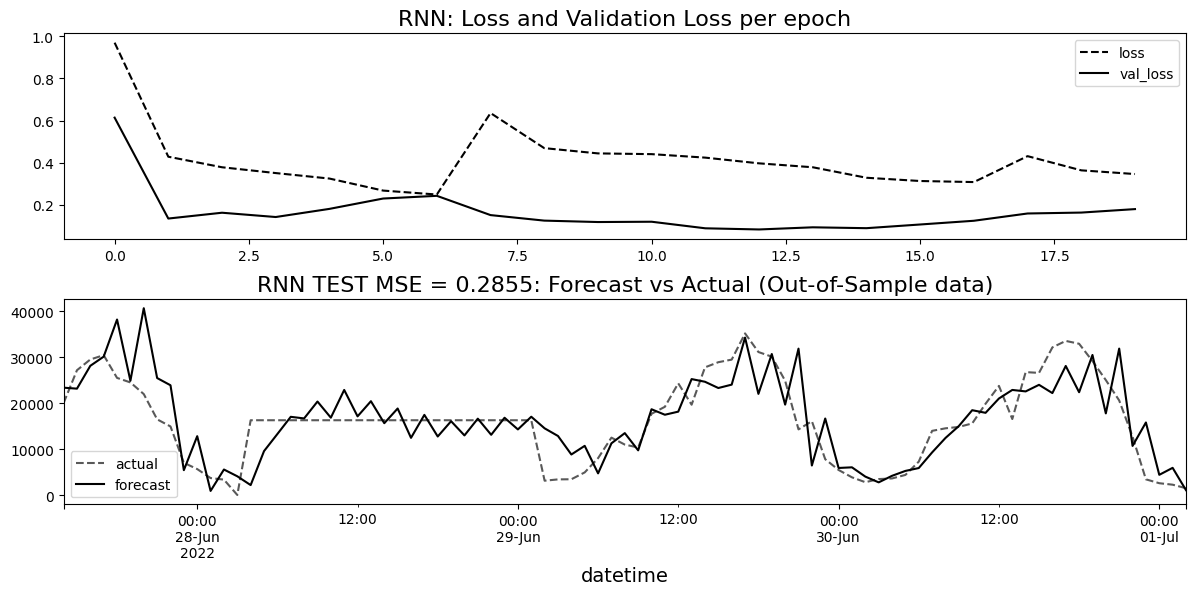

In [140]:
p003_rnn, history_rnn = train_model_pt('RNN', **params)

## LSTM Model

The math from PyTorch LSTM class documentation

$$
\large
\begin{array}{ll} \\
        i_t = \sigma(W_{ii} x_t + b_{ii} + W_{hi} h_{t-1} + b_{hi}) \\
        f_t = \sigma(W_{if} x_t + b_{if} + W_{hf} h_{t-1} + b_{hf}) \\
        g_t = \tanh(W_{ig} x_t + b_{ig} + W_{hg} h_{t-1} + b_{hg}) \\
        o_t = \sigma(W_{io} x_t + b_{io} + W_{ho} h_{t-1} + b_{ho}) \\
        c_t = f_t \odot c_{t-1} + i_t \odot g_t \\
        h_t = o_t \odot \tanh(c_t) \\
    \end{array}
$$

In [141]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, n_features, n_layers):
        super(LSTM, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = n_features
        self.lstm = nn.LSTM(input_size, n_features, n_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(n_features, output_size)
        
    def forward(self, x, hn):
        # batch_first=True -> (batch_size, seq_length, input_size)
        x = x.view(1, x.shape[0], x.shape[1])
        lstm_o, hn = self.lstm(x, hn)
        lstm_o = self.dropout(lstm_o)
        # reshape
        lstm_o = lstm_o.view(-1, self.hidden_dim)
        output = self.fc(lstm_o)
        return output, hn

    def init_hidden(self):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, 1, self.hidden_dim).zero_(),
                  weight.new(self.n_layers, 1, self.hidden_dim).zero_())
        return hidden

0/1000 - Loss:  0.9801110029220581, val_loss: 0.701575517654419
50/1000 - Loss:  0.434575617313385, val_loss: 0.13286054134368896
100/1000 - Loss:  0.4016275703907013, val_loss: 0.16937510669231415
150/1000 - Loss:  0.35176658630371094, val_loss: 0.20494957268238068
200/1000 - Loss:  0.3041969835758209, val_loss: 0.2385060340166092
250/1000 - Loss:  0.24800936877727509, val_loss: 0.3252233862876892
300/1000 - Loss:  0.22145012021064758, val_loss: 0.3499373495578766
350/1000 - Loss:  0.20260579884052277, val_loss: 0.311911016702652
400/1000 - Loss:  0.1840287297964096, val_loss: 0.3818081319332123
450/1000 - Loss:  0.18363262712955475, val_loss: 0.3636397421360016
500/1000 - Loss:  0.14415325224399567, val_loss: 0.39990341663360596
550/1000 - Loss:  0.1318788081407547, val_loss: 0.3246079087257385
600/1000 - Loss:  0.1662365198135376, val_loss: 0.2972427308559418
650/1000 - Loss:  0.1305612176656723, val_loss: 0.35444507002830505
700/1000 - Loss:  0.12775613367557526, val_loss: 0.370898

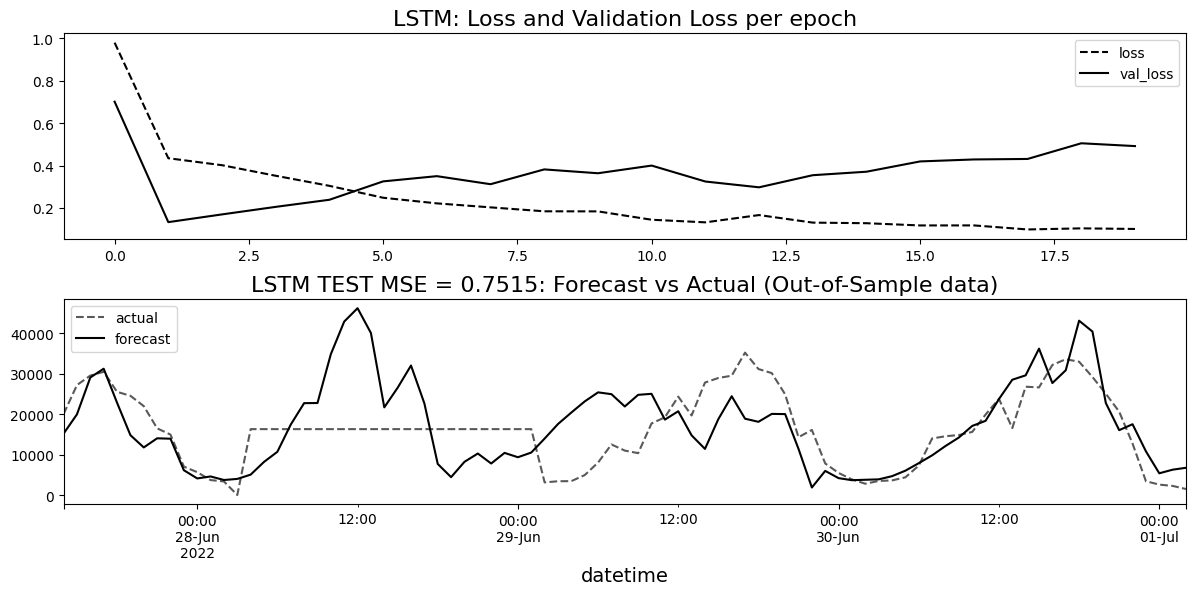

In [142]:
p003_lstm, history_lstm = train_model_pt('LSTM', **params)

In [143]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, n_features, n_layers):
        super(LSTM, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = n_features
        self.lstm = nn.LSTM(input_size, n_features, n_layers, batch_first=True, dropout=0.70)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(n_features, output_size)
        
    def forward(self, x, hn):
        # batch_first=True -> (batch_size, seq_length, input_size)
        x = x.view(1, x.shape[0], x.shape[1])
        lstm_o, hn = self.lstm(x, hn)
        lstm_o = self.dropout(lstm_o)
        # reshape
        lstm_o = lstm_o.view(-1, self.hidden_dim)
        output = self.fc(lstm_o)
        return output, hn

    def init_hidden(self):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, 1, self.hidden_dim).zero_(),
                  weight.new(self.n_layers, 1, self.hidden_dim).zero_())
        return hidden

/Users/phongwitsrikokcharoen/miniconda3/envs/flow/lib/python3.11/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0/1000 - Loss:  0.9981175065040588, val_loss: 0.7635915875434875
50/1000 - Loss:  0.4270293414592743, val_loss: 0.14873938262462616
100/1000 - Loss:  0.3908670246601105, val_loss: 0.19858363270759583
150/1000 - Loss:  0.3513708710670471, val_loss: 0.24273453652858734
200/1000 - Loss:  0.3065478801727295, val_loss: 0.4231323003768921
250/1000 - Loss:  0.4119862914085388, val_loss: 0.316839337348938
300/1000 - Loss:  0.3846997320652008, val_loss: 0.13902631402015686
350/1000 - Loss:  0.32165318727493286, val_loss: 0.20358940958976746
400/1000 - Loss:  0.25729644298553467, val_loss: 0.3036710321903229
450/1000 - Loss:  0.21493470668792725, val_loss: 0.4469292163848877
500/1000 - Loss:  0.18671885132789612, val_loss: 0.5292762517929077
550/1000 - Loss:  0.16492944955825806, val_loss: 0.5988401174545288
600/1000 - Loss:  0.1507938653230667, val_loss: 0.6518863439559937
650/1000 - Loss:  0.1482812911272049, val_loss: 0.7007715106010437
700/1000 - Loss:  0.13501672446727753, val_loss: 0.68765

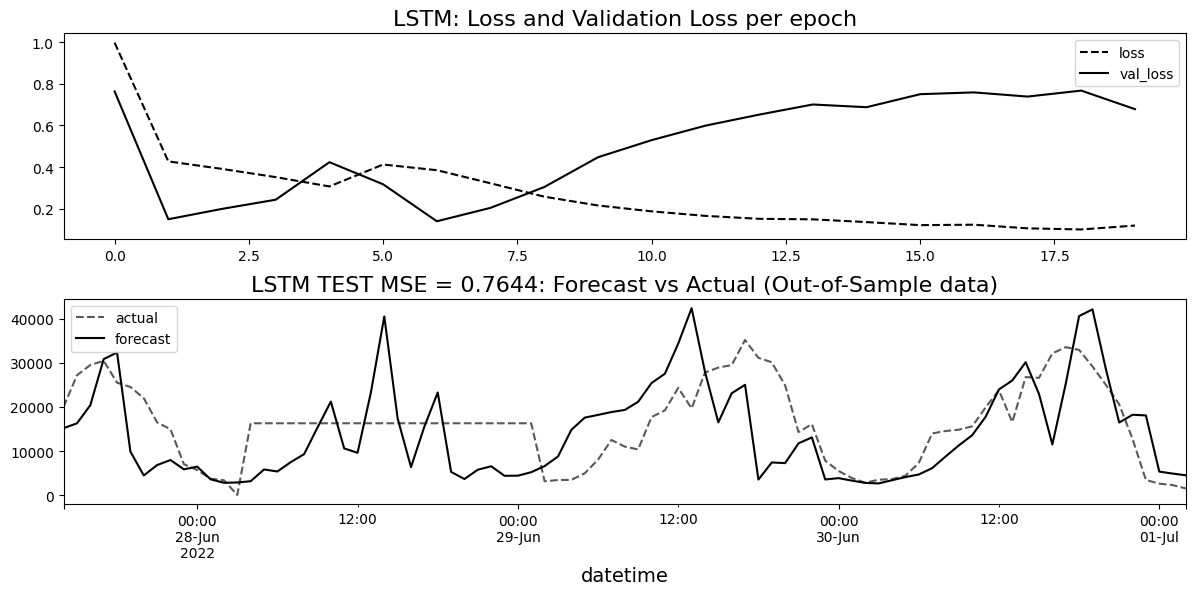

In [144]:
p003_lstm_d, history_lstm_d = train_model_pt('LSTM', **params)

## GRU Model

The math from PyTorch LSTM class documentation

$$
\large
\begin{array}{ll}
        r_t = \sigma(W_{ir} x_t + b_{ir} + W_{hr} h_{(t-1)} + b_{hr}) \\
        z_t = \sigma(W_{iz} x_t + b_{iz} + W_{hz} h_{(t-1)} + b_{hz}) \\
        n_t = \tanh(W_{in} x_t + b_{in} + r_t * (W_{hn} h_{(t-1)}+ b_{hn})) \\
        h_t = (1 - z_t) * n_t + z_t * h_{(t-1)}
    \end{array}
$$

In [145]:
class GRU(nn.Module):
    def __init__(self, input_size, output_size, n_features, n_layers):
        super(GRU, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = n_features
        self.gru = nn.GRU(input_size, n_features, n_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(n_features, output_size)
        
    def forward(self, x, hn):
        # batch_first=True -> (batch_size, seq_length, input_size)
        x = x.view(1, x.shape[0], x.shape[1])
        gru_o, hn = self.gÇru(x, hn)
        gru_o = self.dropout(gru_o)
        # reshape
        gru_o = gru_o.view(-1, self.hidden_dim)
        output = self.fc(gru_o)
        return output, hn

    def init_hidden(self):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, 1, self.hidden_dim).zero_()
        return hidden

/Users/phongwitsrikokcharoen/miniconda3/envs/flow/lib/python3.11/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0/1000 - Loss:  1.0793757438659668, val_loss: 0.8615365028381348
50/1000 - Loss:  0.43323901295661926, val_loss: 0.12174396961927414
100/1000 - Loss:  0.38810649514198303, val_loss: 0.19848643243312836
150/1000 - Loss:  0.35343465209007263, val_loss: 0.21616117656230927
200/1000 - Loss:  0.33260881900787354, val_loss: 0.27118560671806335
250/1000 - Loss:  0.31888237595558167, val_loss: 0.3019808232784271
300/1000 - Loss:  0.2733566462993622, val_loss: 0.6477943658828735
350/1000 - Loss:  0.2226335108280182, val_loss: 0.7312782406806946
400/1000 - Loss:  0.1979004144668579, val_loss: 0.5442976951599121
450/1000 - Loss:  1.005936861038208, val_loss: 0.7085816264152527
500/1000 - Loss:  0.6786067485809326, val_loss: 0.23025262355804443
550/1000 - Loss:  0.5930182337760925, val_loss: 0.20999599993228912
600/1000 - Loss:  0.6142102479934692, val_loss: 0.19530463218688965
650/1000 - Loss:  0.6033742427825928, val_loss: 0.18937954306602478
700/1000 - Loss:  0.5764245390892029, val_loss: 0.183

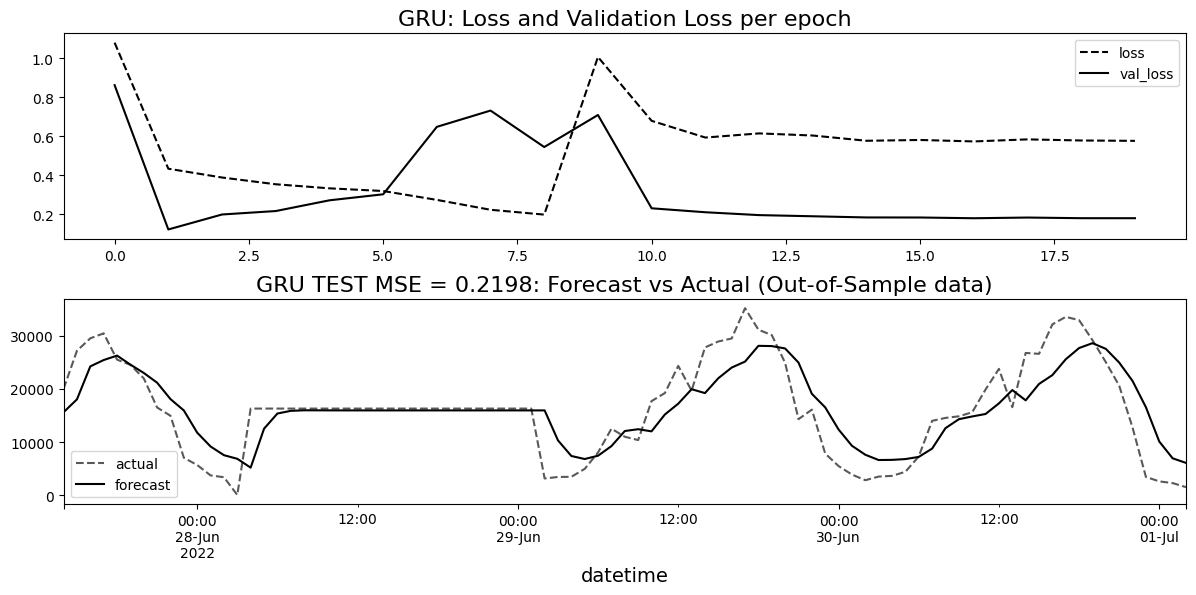

In [146]:
p003_gru, history_gru = train_model_pt('GRU', **params)